In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=706a0649862c9d1967f7e779a41d6801d0bebcff114fe5404fbb7aaf5e9bed27
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 5)

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, DateType, IntegerType, ArrayType, FloatType
from pyspark.sql.functions import *

path:str = '/content/drive/MyDrive/data/spotify-data.csv'
spark = SparkSession.Builder().appName("spotify-data").getOrCreate()

In [5]:
df_schema = StructType([
    StructField('id', StringType(), True),
    StructField('name', StringType(), True),
    StructField("artists", StringType(), True),
    StructField('duration_ms', FloatType(), True),
    StructField('release_date', StringType(), True),
    StructField('year', IntegerType(), True),
    StructField('acousticness', FloatType(), True),
    StructField('danceability', FloatType(), True),
    StructField('energy', FloatType(), True),
    StructField('instrumentalness', FloatType(), True),
    StructField('liveness', FloatType(), True),
    StructField('loudness', FloatType(), True),
    StructField('speechiness', FloatType(), True),
    StructField('tempo', FloatType(), True),
    StructField('valence', FloatType(), True),
    StructField('mode', IntegerType(), True),
    StructField('key', IntegerType(), True),
    StructField('popularity', IntegerType(), True),
    StructField('explicit', IntegerType(), True),
])

df = spark.read.format("csv").option("header", True).schema(df_schema).load(path)

In [6]:
df.show()

+--------------------+--------------------+--------------------+-----------+------------+----+------------+------------+-------+----------------+--------+--------+-----------+-------+-------+----+---+----------+--------+
|                  id|                name|             artists|duration_ms|release_date|year|acousticness|danceability| energy|instrumentalness|liveness|loudness|speechiness|  tempo|valence|mode|key|popularity|explicit|
+--------------------+--------------------+--------------------+-----------+------------+----+------------+------------+-------+----------------+--------+--------+-----------+-------+-------+----+---+----------+--------+
|6KbQ3uYMLKb5jDxLF...|Singende Bataillo...| ['Carl Woitschach']|   158648.0|        1928|1928|       0.995|       0.708|  0.195|           0.563|   0.151| -12.428|     0.0506|118.469|  0.779|   1| 10|         0|       0|
|6KuQTIu1KoTTkLXKr...|Fantasiestücke, O...|['Robert Schumann...|   282133.0|        1928|1928|       0.994|       0.

In [7]:
#Artistas como array de strings
df = df.withColumn("artists", regexp_replace("artists", r"^\[|\]$", ""))
df = df.withColumn("artists", regexp_replace("artists", r"'", ""))
df = df.withColumn("artists", split("artists", ", "))
df = df.withColumn("artists", col("artists").cast(ArrayType(StringType())))

In [8]:
#Tratamento de datas
df = df.withColumn("release_date",
            when(size(split(df.release_date, "/")) == 1, concat(lit("01/01/"), df.release_date))
            .otherwise(df.release_date)
    )


df = df.withColumn('release_date',
              when(split(df.release_date, "/").getItem(2) != df.year,
                   concat(split(df.release_date, "/").getItem(0),
                                lit("/"),
                                split(df.release_date, "/").getItem(1),
                                lit("/"),
                                df.year))
                    .otherwise(df.release_date)
        )

df = df.withColumn("release_day", lpad(split(df.release_date, "/").getItem(1), 2, "0"))
df = df.withColumn("release_month", lpad(split(df.release_date, "/").getItem(0), 2, "0"))
df = df.withColumn("release_date", concat(df.release_day, lit("-"), df.release_month, lit("-"),  df.year))
df = df.withColumn("release_date", to_date(df["release_date"], "dd-MM-yyyy"))
df = df.drop(col("release_day"), col("release_month"), col("id"))

df = df.withColumn("year", col("year").cast(StringType()))
df = df.filter(length(df.year) == 4)
df = df.withColumn("year", col("year").cast(IntegerType()))

df.show()

+--------------------+--------------------+-----------+------------+----+------------+------------+-------+----------------+--------+--------+-----------+-------+-------+----+---+----------+--------+
|                name|             artists|duration_ms|release_date|year|acousticness|danceability| energy|instrumentalness|liveness|loudness|speechiness|  tempo|valence|mode|key|popularity|explicit|
+--------------------+--------------------+-----------+------------+----+------------+------------+-------+----------------+--------+--------+-----------+-------+-------+----+---+----------+--------+
|Singende Bataillo...|   [Carl Woitschach]|   158648.0|  1928-01-01|1928|       0.995|       0.708|  0.195|           0.563|   0.151| -12.428|     0.0506|118.469|  0.779|   1| 10|         0|       0|
|Fantasiestücke, O...|[Robert Schumann,...|   282133.0|  1928-01-01|1928|       0.994|       0.379| 0.0135|           0.901|  0.0763| -28.454|     0.0462| 83.972| 0.0767|   1|  8|         0|       0|


In [9]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- artists: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- duration_ms: float (nullable = true)
 |-- release_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- key: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- explicit: integer (nullable = true)



In [10]:
noarray_artists = df.withColumn("artists", explode(col("artists")))
noarray_artists = noarray_artists.withColumn("artists", trim(regexp_replace(col("artists"), "[\[\]']", "")))

In [11]:
avg_general = noarray_artists.groupBy("artists") \
    .agg(
        avg("popularity").alias("avg-popularity"),
        avg("explicit").alias("avg-explicit"),
        (avg("duration_ms")/(1000 * 60)).alias("avg-duration-minutes")
    ) \
    .sort("avg-popularity", ascending=False) \

avg_general.show()

+---------------+-----------------+------------+--------------------+
|        artists|   avg-popularity|avg-explicit|avg-duration-minutes|
+---------------+-----------------+------------+--------------------+
|         Emilee|             95.0|         0.0|             2.94245|
| StaySolidRocky|             94.0|         0.0|  2.4633333333333334|
|            A7S|             92.0|         0.0|              2.7799|
|          Topic|             92.0|         0.0|              2.7799|
|         Regard|             90.0|         0.0|  2.6267666666666667|
|    J. Rey Soul|             90.0|         1.0|   4.152383333333334|
|         Juanka|             87.0|         1.0|   5.754016666666667|
|          Brray|             87.0|         1.0|   5.754016666666667|
|    Sam Fischer|             86.0|         0.0|             3.24755|
|    Dímelo Flow|             86.0|         0.0|  3.9671083333333335|
|          Alida|             86.0|         0.0|  3.4703666666666666|
|            DTG|   

In [12]:
avg_by_year = noarray_artists \
    .groupBy("year") \
    .agg(
        (avg("popularity") / 100).alias('avg-popularity-by-year'),
        (avg("duration_ms")/(1000 * 60)).alias("avg-duration-minutes"),
        avg("energy").alias("avg-energy-by-year"),
        avg("explicit").alias("avg-explicit")
    ) \
    .sort("avg-popularity-by-year", ascending=True) \

avg_by_year.show()

+----+----------------------+--------------------+-------------------+--------------------+
|year|avg-popularity-by-year|avg-duration-minutes| avg-energy-by-year|        avg-explicit|
+----+----------------------+--------------------+-------------------+--------------------+
|1922|  0.001388888888888889|   2.798409027777778|0.23702624916202492|                 0.0|
|1929|  0.002883333333333...|           3.1396675|0.23905299958617737|               0.365|
|1921|  0.004581005586592179|   4.670959124767226|0.20555809937292638| 0.03910614525139665|
|1940|  0.008430389510219823|  3.1286118717058744|  0.329206047141955| 0.15079059005013498|
|1931|   0.00896694214876033|  2.9694889297385623| 0.2709299617773235|                 0.0|
|1941|  0.009542682926829268|  3.4805473684210524|0.23087559784208878| 0.03841463414634146|
|1943|  0.009642126789366053|   4.348228766189503| 0.2802077306354521|                 0.0|
|1947|  0.009654255319148937|   4.433049340687207|0.23918240132747293|0.00265957

<Axes: xlabel='year'>

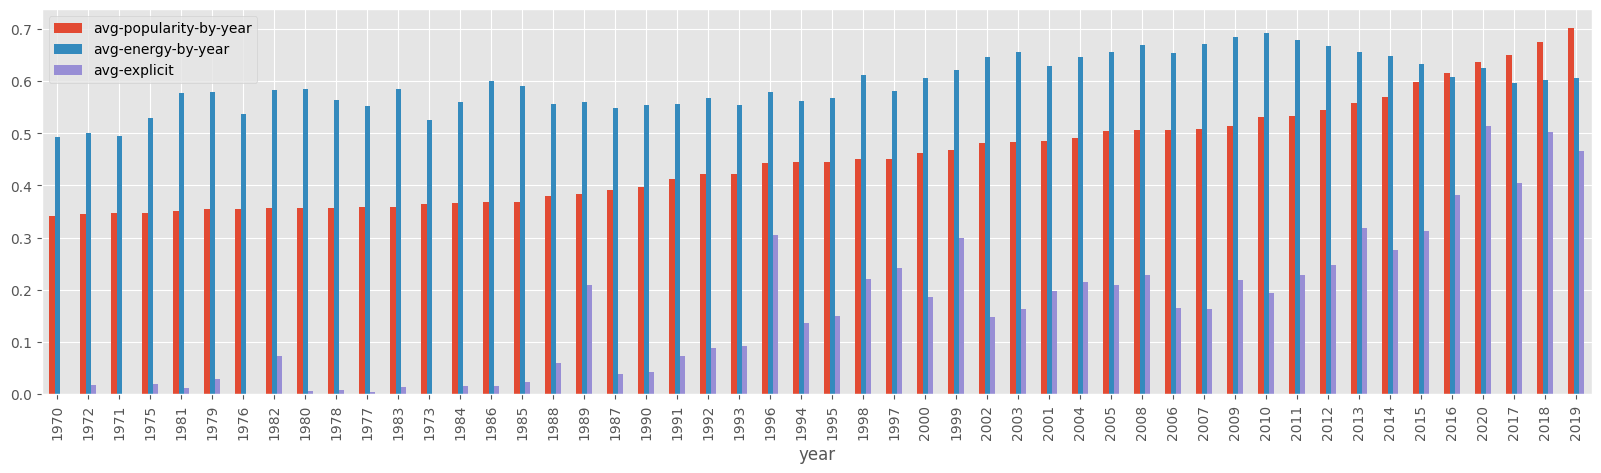

In [13]:
df_PopularityYear = avg_by_year.select(col("year"),
                                       col("avg-popularity-by-year"),
                                       col('avg-energy-by-year'),
                                       col("avg-explicit")
                                       ).toPandas().iloc[50:,:]

df_PopularityYear.plot.bar(x='year')

<Axes: xlabel='year'>

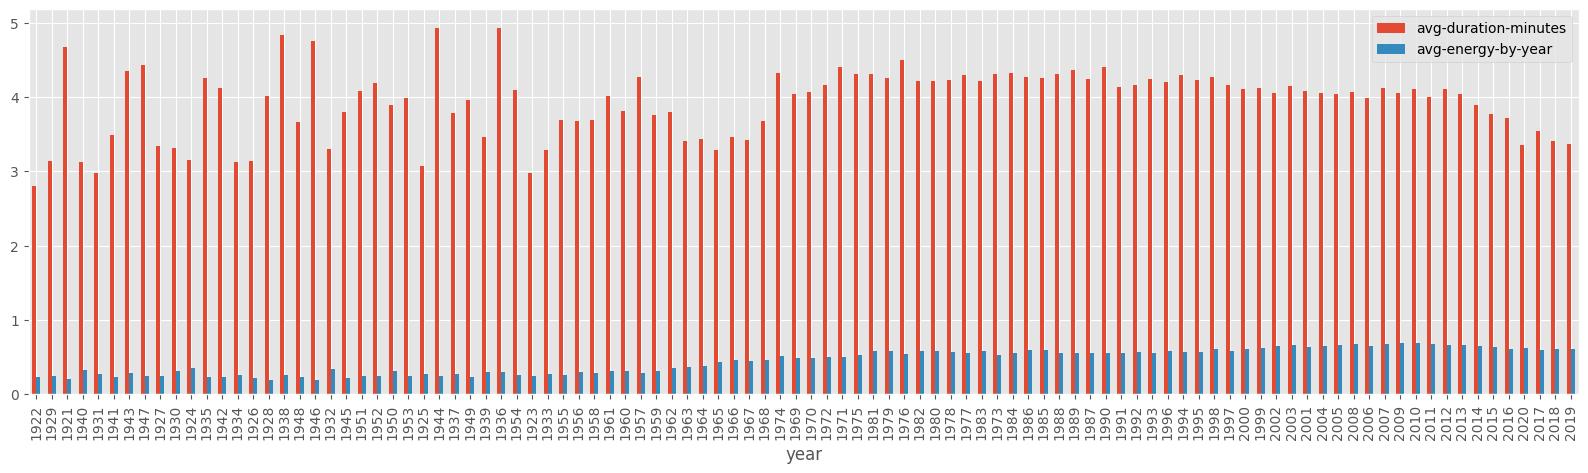

In [14]:
df_avg = avg_by_year.select(col("year"),
                            col('avg-duration-minutes'),
                            col("avg-energy-by-year")
                        ).toPandas().iloc[:,:]

df_avg.plot.bar(x='year')

In [15]:
from pyspark.sql import Window

newartists = noarray_artists.filter(df.year > 2000)
newartists = newartists.drop("release_date")

newartists = newartists \
    .groupBy("artists") \
    .agg(
        count("artists").alias("Aparições"),
        (avg("duration_ms") / (1000 * 60)).alias("Duração Média em Minutos"),
        avg("energy").alias("Energia Média")
    ) \
    .sort("Aparições", ascending=False) \
    .withColumnRenamed("artists", "Artista") \

window = Window.orderBy(col("Aparições").desc())
ranked_artists = newartists \
    .withColumn("Ranking Aparições", rank() \
    .over(window)) \

ranked_artists.show()

+--------------+---------+------------------------+------------------+-----------------+
|       Artista|Aparições|Duração Média em Minutos|     Energia Média|Ranking Aparições|
+--------------+---------+------------------------+------------------+-----------------+
|         Drake|      317|       4.134185068349106|0.5873804425685564|                1|
|     Lil Wayne|      241|       4.208795435684647|0.6913070541447129|                2|
|        Eminem|      225|       4.560006888888889|0.7639986678626802|                3|
|    Kanye West|      222|      4.0517755255255254|0.6475549546313716|                4|
|  Taylor Swift|      207|       3.987240338164251| 0.633874396627076|                5|
|         JAY-Z|      180|      4.2953362037037035|0.7789277760518922|                6|
|        Future|      150|      3.7508157777777775|0.5703200004498163|                7|
|   Chris Brown|      143|      3.9349392773892773|0.6401748257083493|                8|
|    Mac Miller|     

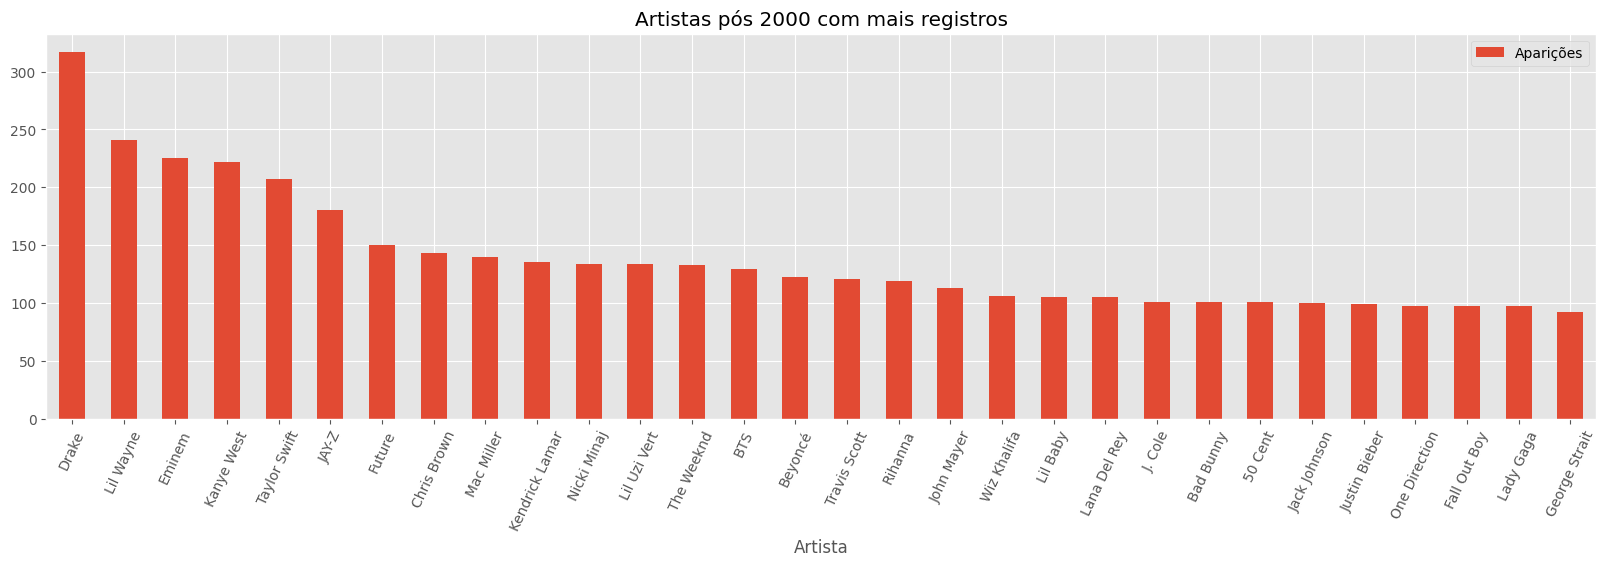

In [16]:
pd_ranked = ranked_artists.toPandas().iloc[:30]

pd_ranked.plot.bar(x='Artista', y='Aparições', rot=65)
plt.title("Artistas pós 2000 com mais registros")
plt.show()

Text(0.5, 1.0, 'Relação entre Energia e Instrumentalidade média das músicas no decorrer do tempo')

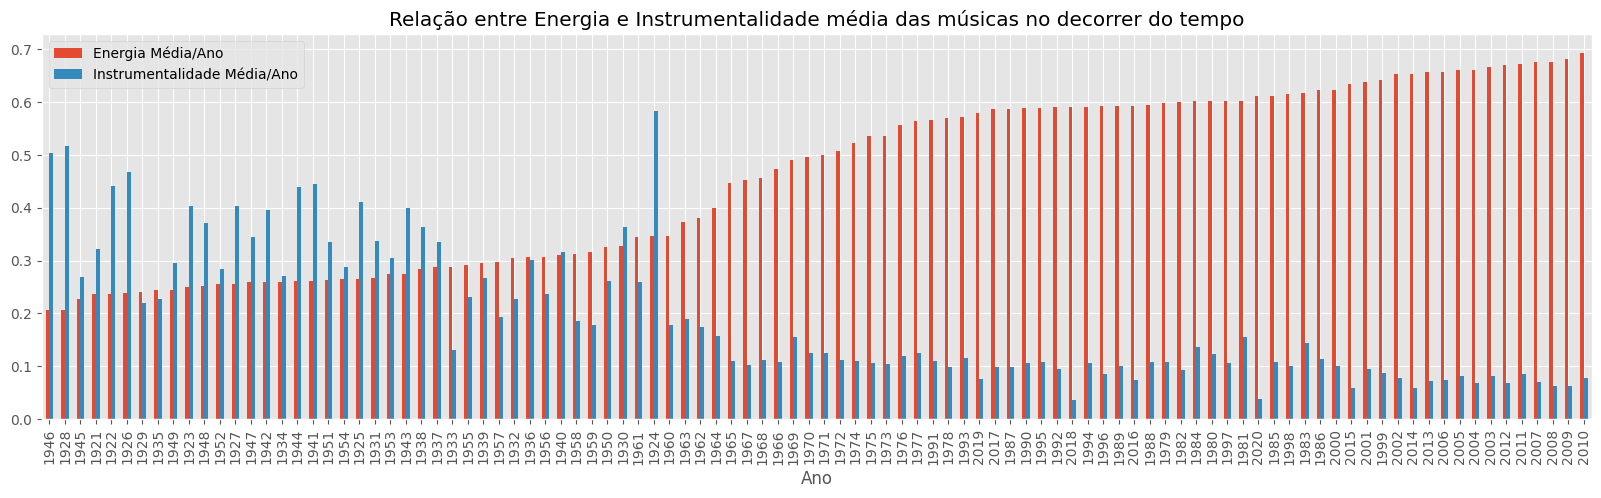

In [17]:
avg_energy = df.groupBy("year") \
    .agg(
        avg("energy").alias("Energia Média/Ano"),
        avg("instrumentalness").alias("Instrumentalidade Média/Ano"),
    ) \
    .sort("Energia Média/Ano", ascending=True) \
    .withColumnRenamed("year", "Ano") \

pd_energy = avg_energy.toPandas()
pd_energy.plot.bar(x="Ano")
plt.title("Relação entre Energia e Instrumentalidade média das músicas no decorrer do tempo")

Text(0.5, 1.0, 'Correlação entre variáveis numéricas que caracterizam as músicas')

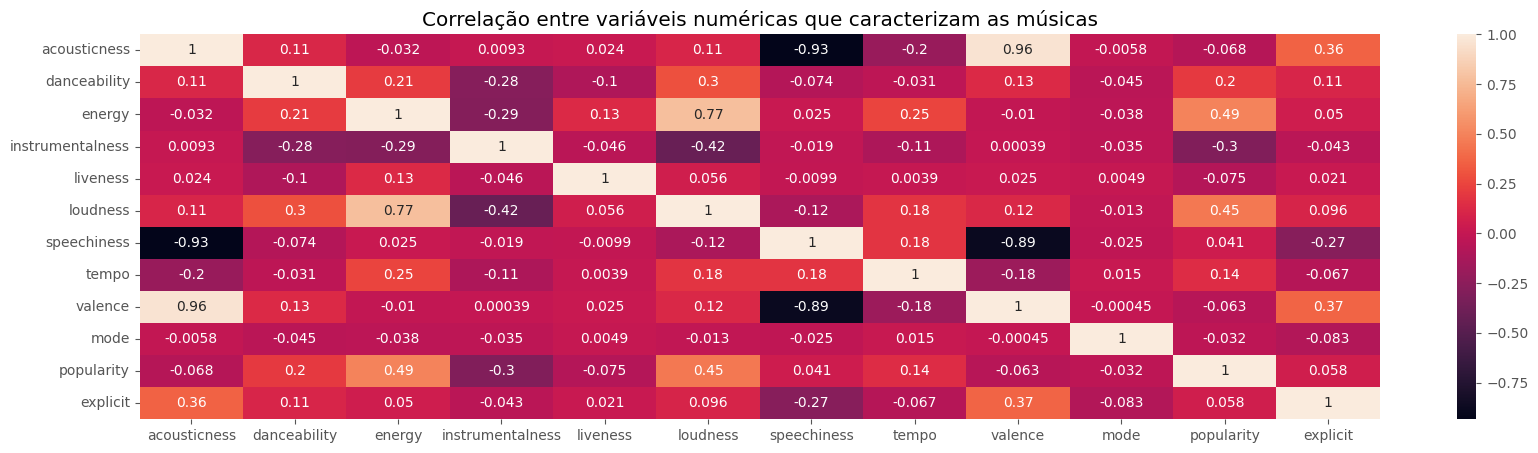

In [18]:
import seaborn as sns

song_num = df.select(col("acousticness"),       col("danceability"),    col("energy"),
                     col("instrumentalness"),   col("liveness"),        col("loudness"),
                     col("speechiness"),        col("tempo"),           col("valence"),
                     col("mode"),               col("popularity"),      col("explicit"))
pd_song = song_num.toPandas()

sns.heatmap(pd_song.corr(), annot=True)
plt.title("Correlação entre variáveis numéricas que caracterizam as músicas")

In [19]:
pd_song.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,popularity,explicit
count,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168466.000000,168932.000000,168932.000000
mean,5.918082,0.540420,0.490180,0.162002,0.206639,-11.295107,0.044233,116.733719,0.818268,0.708309,31.658519,0.099046
std,102.766373,0.175853,0.266888,0.308979,0.177627,5.667491,1.009722,31.275940,5.627904,0.454542,21.542315,0.723490
min,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,-49.286999,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.093400,0.419000,0.265000,0.000000,0.098200,-14.384000,0.034800,93.507004,0.326000,0.000000,12.000000,0.000000
50%,0.488000,0.550000,0.482000,0.000207,0.135000,-10.413000,0.044900,114.796497,0.548000,1.000000,34.000000,0.000000
75%,0.886000,0.669000,0.711000,0.089900,0.262000,-7.072000,0.075200,135.738998,0.753000,1.000000,48.000000,0.000000
max,2009.000000,0.996000,1.000000,1.000000,1.000000,3.855000,0.969000,244.091003,207.832001,1.000000,100.000000,68.000000


Text(0.5, 1.0, 'energy vs. popularity')

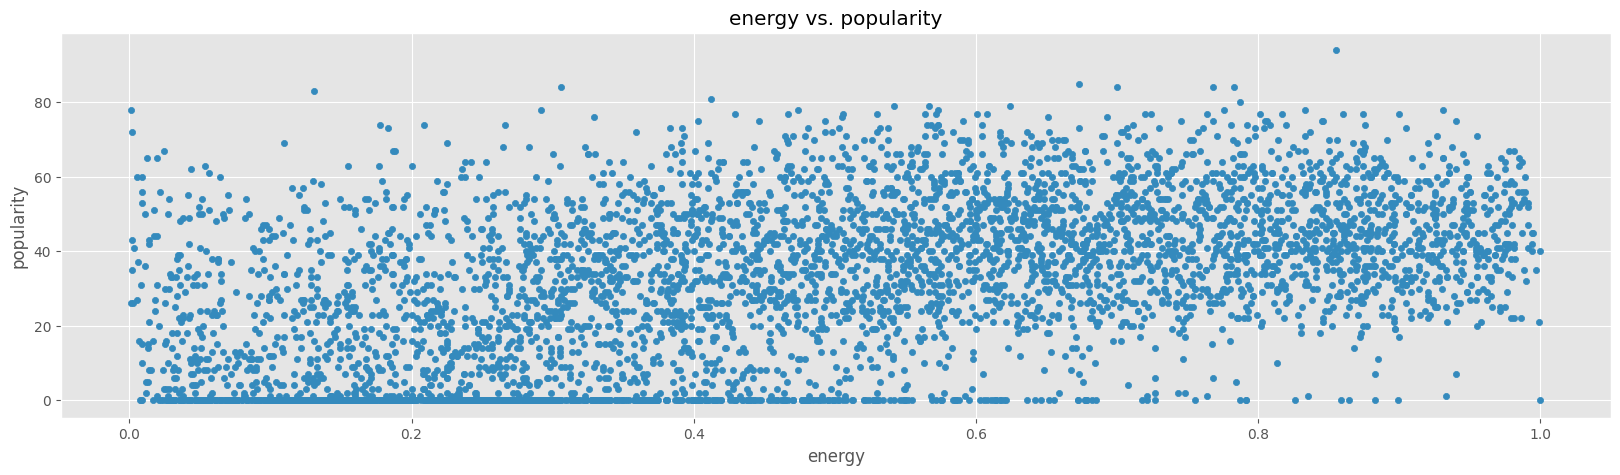

In [20]:
x, y, n = 'energy', 'popularity', 5000
scatter_01 = song_num.select(col(x), col(y)).toPandas().sample(n).plot.scatter(x,y)

plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{x} vs. {y}')

Text(0.5, 1.0, 'loudness vs. energy')

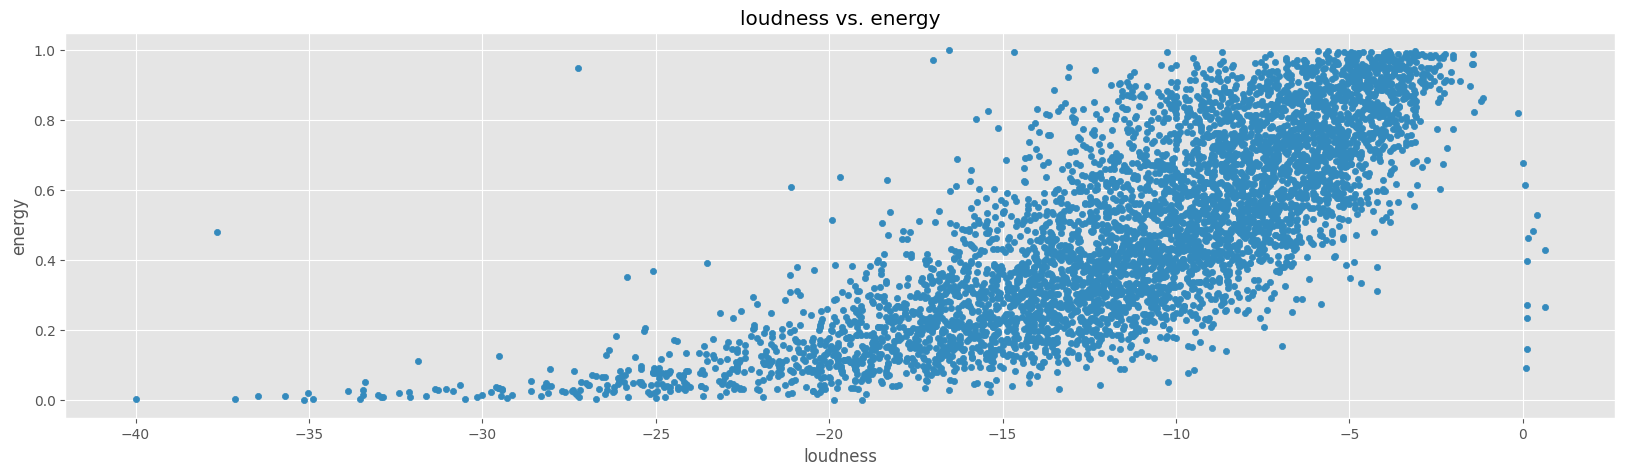

In [21]:
x, y = 'loudness', 'energy'
scatter_02 = song_num.select(col(x), col(y)).toPandas().sample(n).plot.scatter(x,y)

plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{x} vs. {y}')

Text(0.5, 1.0, 'instrumentalness vs. loudness')

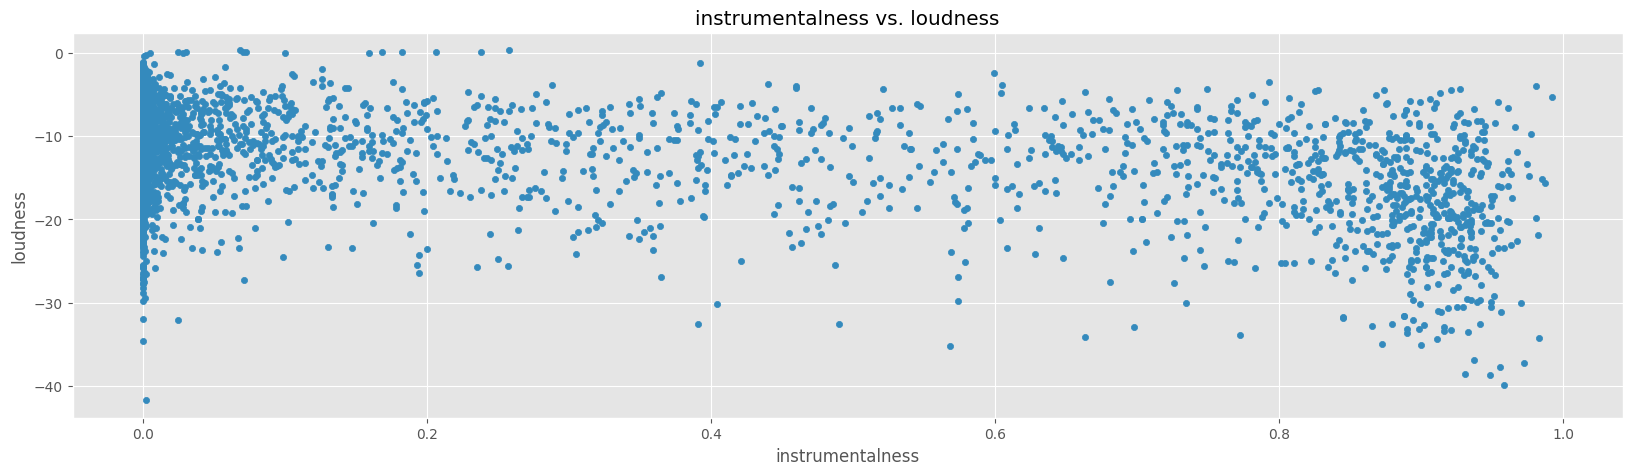

In [22]:
y, x = 'loudness', 'instrumentalness'
scatter_03 = song_num.select(col(x), col(y)).toPandas().sample(n).plot.scatter(x,y)

plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{x} vs. {y}')

1. Feature Pre-Processing
    - 1.1: Fill Null Values With Median
    - 1.2: MinMaxScaler
2. Machine Learning (non-linear) Model Training
  - 2.1: RandomForest()
  - 2.2: XGBoost()

In [23]:
max_width = np.max([len(x) for x in pd_song.columns])

for col in pd_song.columns:
    print(f'{col.ljust(max_width)} {pd_song[col].isnull().sum()}')

acousticness     0
danceability     0
energy           0
instrumentalness 0
liveness         0
loudness         0
speechiness      0
tempo            0
valence          0
mode             466
popularity       0
explicit         0


In [24]:
pd_song[['mode']] = pd_song[['mode']].fillna(pd_song[['mode']].median())
print('mode null sum:', pd_song['mode'].isnull().sum())

mode null sum: 0


In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

mm_scaler, rf, xgb = MinMaxScaler(feature_range=(0, 1)), RandomForestRegressor(), XGBRegressor()

feature_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode', 'popularity', 'explicit']
pd_song[feature_cols] = mm_scaler.fit_transform(pd_song[feature_cols])

pd_song.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,popularity,explicit
count,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000,168932.000000
mean,0.002946,0.542590,0.490181,0.162002,0.206639,0.762742,0.981599,0.478238,0.003937,0.709114,0.316585,0.001457
std,0.051153,0.176560,0.266889,0.308979,0.177627,0.088756,0.020092,0.128132,0.027079,0.454173,0.215423,0.010640
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000046,0.420683,0.265000,0.000000,0.098200,0.714368,0.981411,0.383083,0.001569,0.000000,0.120000,0.000000
50%,0.000243,0.552209,0.482000,0.000207,0.135000,0.776556,0.981612,0.470302,0.002637,1.000000,0.340000,0.000000
75%,0.000441,0.671687,0.711000,0.089900,0.262000,0.828878,0.982215,0.556100,0.003623,1.000000,0.480000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
X, y = pd_song.drop(['popularity'], axis='columns'), pd_song[['popularity']]

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=1/3)
print(f'xtrain and xtest shape: {xtrain.shape}, {xtest.shape}')

rf.fit(xtrain.to_numpy(),
       ytrain.to_numpy().ravel())


y_pred_rf = rf.predict(xtest)
mse_rf = mean_squared_error(ytest, y_pred_rf)
score_rf = rf.score(xtest, ytest)

print(f'mean squared error - RandomForestRegressor: {mse_rf}')

xtrain and xtest shape: (112621, 11), (56311, 11)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


mean squared error - RandomForestRegressor: 0.01858963958040454


In [27]:
xgb.fit(xtrain, ytrain.to_numpy().ravel())
y_pred_xgb = xgb.predict(xtest)
mse_xgb = mean_squared_error(ytest, y_pred_xgb)

print(f'mean squared error - XGBoost: {mse_xgb}')

mean squared error - XGBoost: 0.01866932554574164
